# HD 155358
This notebook is a messaround version where I'm fitting e and w instead of h and k

In [1]:
import pandas as pd
import numpy as np
import rebound
import emcee
import multiprocessing

import corner
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("RV.txt", delimiter=' ')

In [4]:
#Don't want to move to COM, want to see relative to the background. 
def fit_RV(times,theta):
    m1sini,m2sini,a1,a2,e1,e2,w1,w2,M1,M2,sini = theta
    AUyr2ms = 29682.77                   #AU/(yr/2pi) -> m/s
    dtoyr2pi = 2*np.pi/365.              #days -> yr/2pi
    mJ = 9.543e-4                        #Jupiter mass -> solar mass
    
    v = np.empty(0)    
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.add(m=0.92)                      #add the star
    sim.dt = 2*np.pi* a1**(1.5) / 50.    #dt = 50 steps per orb per of inner planet
    sim.add(m=m1sini*mJ/sini,a=a1,M=M1,e=e1,omega=w1) 
    sim.add(m=m2sini*mJ/sini,a=a2,M=M2,e=e2,omega=w2)  
    sim.move_to_com()
    orbit1 = sim.particles[1].calculate_orbit(sim.particles[0])
    orbit2 = sim.particles[2].calculate_orbit(sim.particles[0])
    #print orbit1.e*np.sin(orbit1.pomega), orbit1.e*np.cos(orbit1.pomega), orbit2.e*np.sin(orbit2.pomega), orbit2.e*np.cos(orbit2.pomega), orbit1.pomega, orbit2.pomega
    for t in times*dtoyr2pi:
        sim.integrate(t)
        v = np.append(v,-AUyr2ms*sim.particles[0].vy*sini)
        #vyp = (vx*np.sin(phi) + vy*np.cos(phi))*sini #coordinate transf from (x,y,z)->(x',y',z'), take y' component
        #v = np.append(v,AUyr2ms*vyp)
    return v 

## Chicken Scratch

In [5]:
#conv
dtoR = np.pi/180.                          #degrees -> radians

#data
t0 = data["BJD"].iloc[0]
times = data["BJD"] - t0                   #in Barycentric Julian Date (days)
m1sini,m2sini = 0.9163,0.851                  #Jupiter masses, default 0.85,0.82
a1,a2 = 0.643,1.017                          #AU, default: 0.64, 1.02
e1,e2 = 0.142,1.58e-6                          #default: 0.17,0.16
w1,w2 = 2.86,1.30                          #in radians, default: 143, 180
M1,M2 = 2.310,6.176                         #in degrees, default: 129, 233
#observer angles - I dont think I need phi, since that just shifts w
sini = 0.984                                 #inclination angle (sini = 0-1)

tt = np.linspace(t0,max(data["BJD"]),300)
times = tt - t0

#fit
theta = m1sini,m2sini,a1,a2,e1,e2,w1,w2,M1,M2,sini
RV = fit_RV(times,theta)

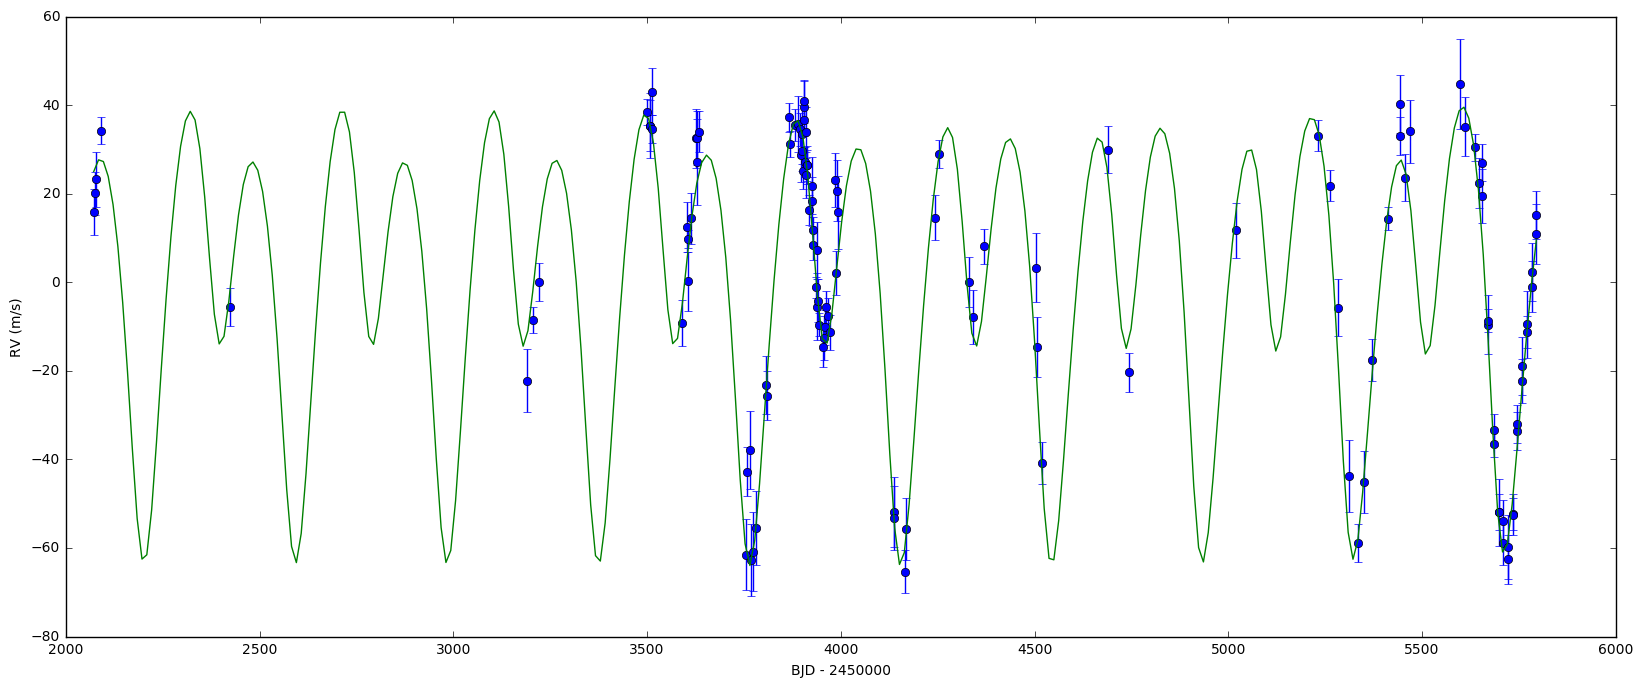

In [6]:
plt.figure(figsize=(20,8))
plt.errorbar(data["BJD"],data["RV"], yerr=data["Unc"], fmt='o')
#plt.plot(data["BJD"],RV, 'o')
plt.plot(tt,RV)
plt.xlabel("BJD - 2450000")
plt.ylabel("RV (m/s)")

## Emcee

In [24]:
def lnlike(theta_j, times, y, yerr2):
    theta, jitter2 = theta_j[:-1], theta_j[-1]
    model = fit_RV(times,theta)
    return -0.5*np.sum( (y - model)**2/(yerr2 + jitter2) + np.log(yerr2 + jitter2) )
    #return -0.5*np.sum( (y - model)**2/(yerr2) + np.log(yerr2) )

def lnprior(theta_j):
    m1sini,m2sini,a1,a2,e1,e2,w1,w2,M1,M2,sini,jitter2 = theta_j
    if 0.4<m1sini<2 and 0.4<m2sini<2 and 0.4<a1<0.75 and 0.8<a2<1.4 and 0<e1<1. and 0<e2<1. and 0<=w1<2*np.pi and 0<=w2<2*np.pi and 0.<=M1<=2*np.pi and 0.<=M2<=2*np.pi and 0.05<=sini<=1. and 0.<jitter2<20.:
        return 0   
    return -np.inf 

def lnprob(theta_j, times, y, yerr2):
    lnp = lnprior(theta_j)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta_j, times, y, yerr2)

In [7]:
#data
times = data["BJD"] - data["BJD"].iloc[0] #BJD (days)
m1sini,m2sini = 0.85,0.82                 #Jupiter masses, default 0.85,0.82
a1,a2 = 0.64,1.02                         #AU, default: 0.64, 1.02
e1,e2 = 0.3,0.16                          #default: 0.17,0.16
w1,w2 = 2.86,1.30                         #in radians, default: 143, 180
M1,M2 = 2.310,6.176                       #in degrees, default: 129, 233
sini = 1                                  #inclination angle
jitter2 = 2                               #stellar jitter term squared (m^2/s^2)

theta_ini = [m1sini,m2sini,a1,a2,e1,e2,w1,w2,M1,M2,sini,jitter2]
ndim, nwalkers, n_it = len(theta_ini), 50, 5000

Run the MCMC. **Warning**. This could take a while.

In [28]:
pos = [theta_ini + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(times, data["RV"].values, (data["Unc"].values)**2));
sampler.run_mcmc(pos, n_it);
np.save("round2.npy",sampler.chain)

# Load and analyze data

In [8]:
#Corner plot
burnin = 1000
#filename="emcee_chains/ewfit_nojitter_50walk_1500step"
filename="emcee_chains/ewfit_jitter_nopool_nwalk50_nit1500"
samples = np.load(filename+".npy")[:, burnin:, :].reshape((-1, ndim))

In [9]:
labels=["$m_1sini$","$m_2sini$","$a_1$","$a_2$","$e_1$","$e_2$","$w_1$","$w_2$","$M_1$","$M_2$","$sini$","$jitter2$"]

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


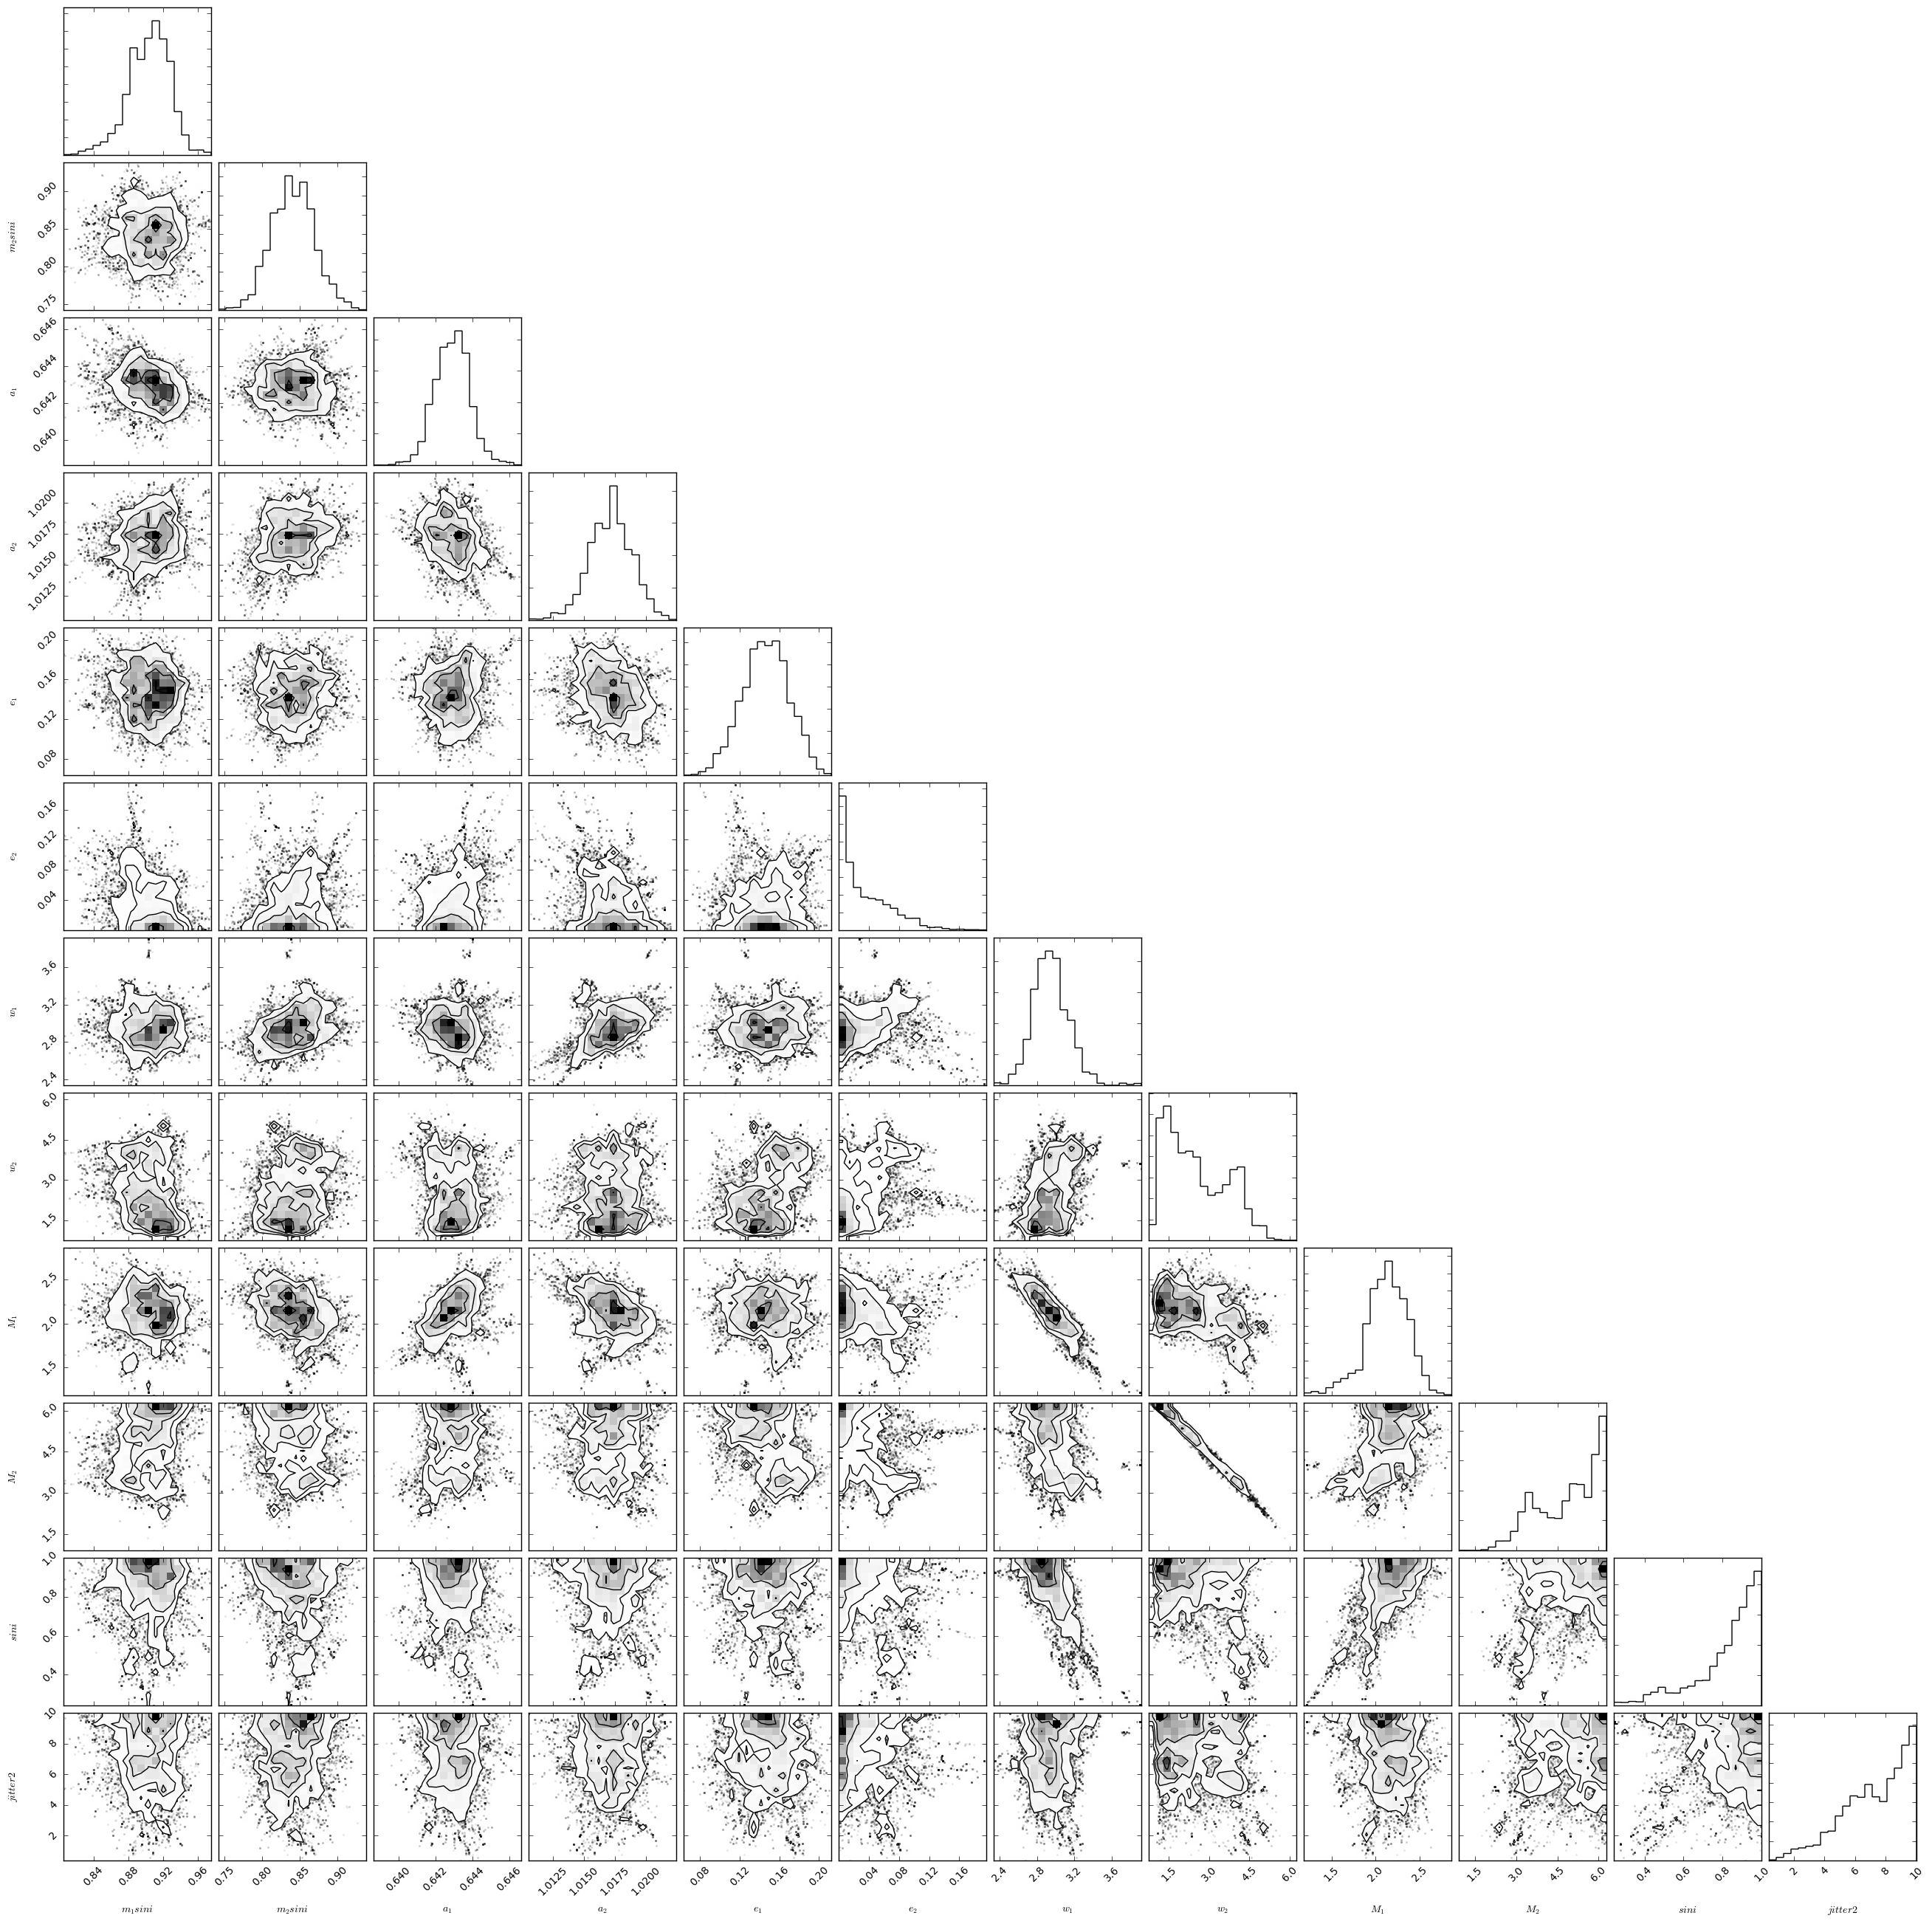

In [12]:
fig = corner.corner(samples, labels=labels)
fig.savefig(filename+"_corner.png")

[(0.90722238321598114, '$m_1sini$'),
 (0.85181060169957212, '$m_2sini$'),
 (0.64328743760852858, '$a_1$'),
 (1.0171873747435918, '$a_2$'),
 (0.14391412807046547, '$e_1$'),
 (1.5818116935626889e-06, '$e_2$'),
 (2.8411070000924927, '$w_1$'),
 (1.3005970721486131, '$w_2$'),
 (2.1244924524052675, '$M_1$'),
 (6.1756355097816753, '$M_2$'),
 (0.98479931488084271, '$sini$'),
 (9.4214644223274444, '$jitter2$')]

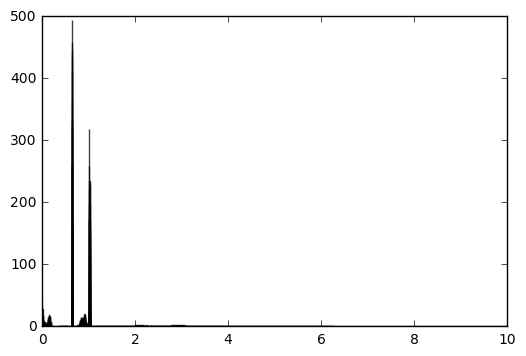

In [10]:
MAP = []
for i in range(ndim):
    n, bins, patches = plt.hist(samples[:,i], 50, normed=1, facecolor='green', alpha=0.75);
    MAP.append(bins[np.argmax(n)])

zip(MAP,labels)

## Plot MAP

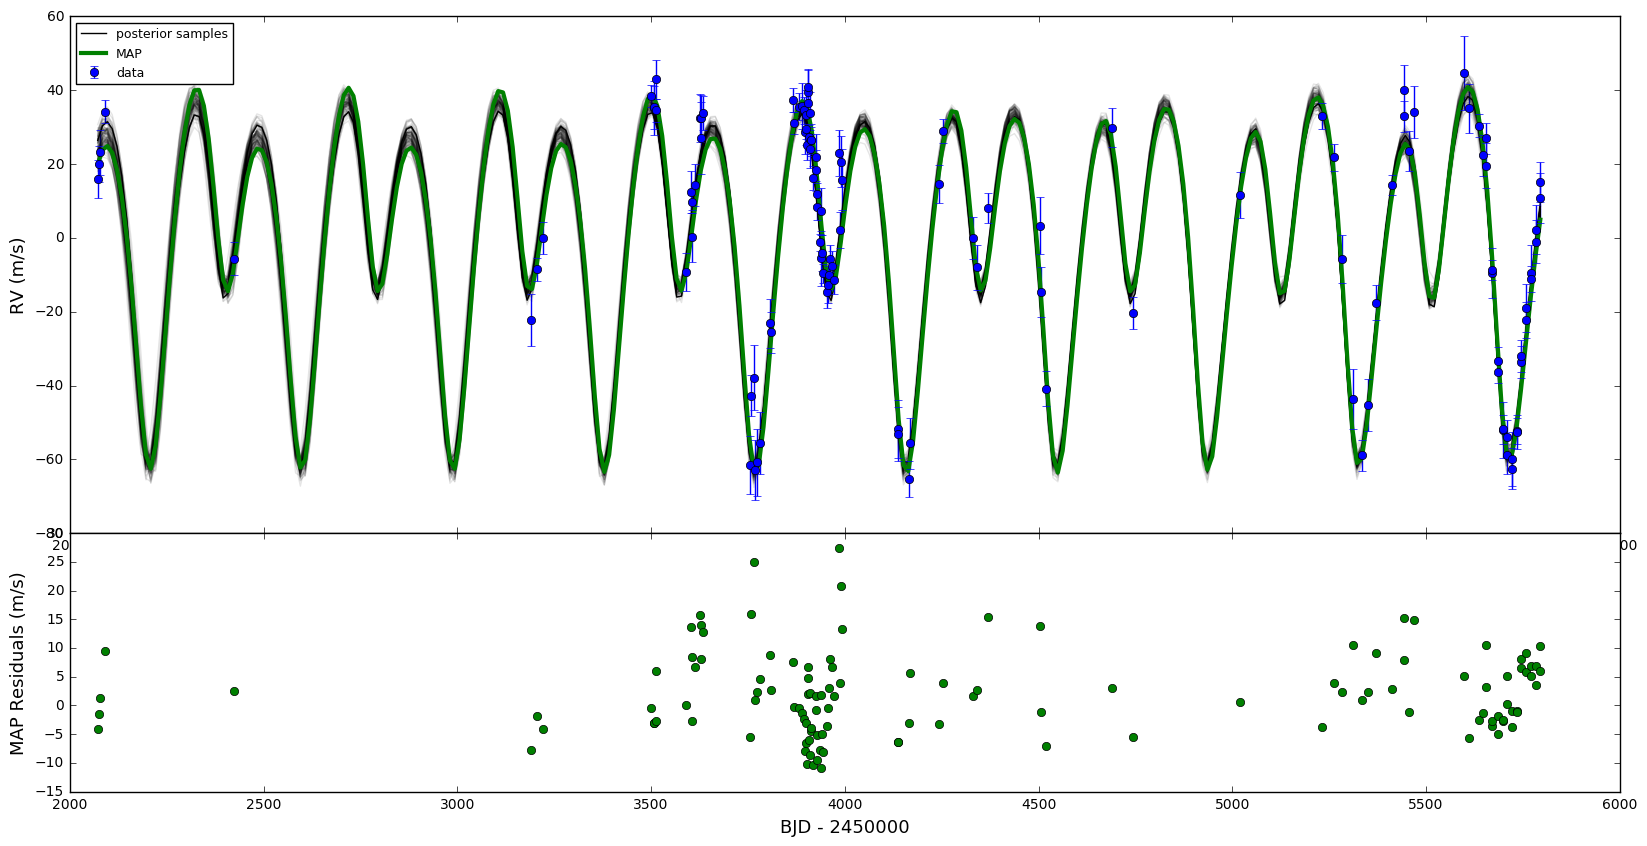

In [11]:
#plotting stuff
from matplotlib import gridspec
fontsize=13
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
axes = [plt.subplot(gs[0]),plt.subplot(gs[1])]
plt.subplots_adjust(hspace = 0)
axes[0].set_ylabel("RV (m/s)",fontsize=fontsize)
axes[1].set_ylabel("MAP Residuals (m/s)",fontsize=fontsize)
axes[1].set_xlabel("BJD - 2450000",fontsize=fontsize)

#samples from posterior
t0 = data["BJD"].iloc[0]
tt = np.linspace(t0,max(data["BJD"]),300)
for theta in samples[np.random.randint(len(samples), size=100)]:
    sampleRV = fit_RV(tt-t0,theta[:-1])
    axes[0].plot(tt,sampleRV,color="k", alpha=0.1)
axes[0].plot(tt,sampleRV,color="k", label='posterior samples')

#MAP
RV = fit_RV(tt-t0,MAP[:-1])
Residuals = data["RV"] - fit_RV(data["BJD"] - data["BJD"].iloc[0],MAP[:-1])
axes[0].plot(tt,RV, color='green',linewidth=3, label='MAP')
axes[0].errorbar(data["BJD"],data["RV"], yerr=data["Unc"], fmt='o', color='blue', label='data')
axes[1].plot(data["BJD"],Residuals, 'o', color='green')

#save
axes[0].legend(loc="upper left",fontsize=9,numpoints=1)
plt.savefig(filename+"_MAP_RV.png")

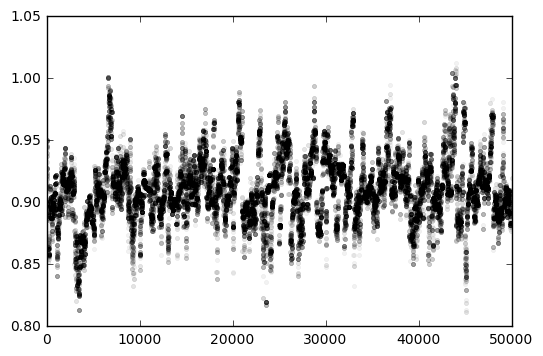

In [29]:
parameter = 0
plt.plot(samples[:,parameter], '.', alpha=0.05, color='black')

In [40]:
print "Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction))